In [9]:
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import random
import sys

#imports for LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

import scipy.stats as stats

np.set_printoptions(threshold=sys.maxsize)
csv.field_size_limit(sys.maxsize)

from sklearn.decomposition import PCA
from time import gmtime, strftime


base_dir = "/home/ehuarotop/Documents/Computer_Science/UFRGS/jupyter-notebooks/projeto-geodigital"
path_dirs = ["accio_my_image_dataset_1.csv","accio_my_image_dataset_2.csv","accio_my_image_dataset_3.csv",
            "accio_my_image_dataset_4.csv","accio_my_image_dataset_5.csv"]

#Join information of the images from both csv file.
images_info = []
headers = []

for path in path_dirs:
    with open(path, 'r') as f:
        reader = csv.reader(f)
        read_images = list(reader)

    #getting headers and csv rows
    headers = read_images[0]
    images_info += read_images[1:]
        
#parsing data read from csv file
for idx, image in enumerate(images_info):
    image[2] = np.fromstring(image[2][1:-1], dtype=np.float32, sep=' ')
    image[3] = np.log(np.fromstring(image[3][2:-2],dtype=np.float32, sep=' ').reshape(256,1)[:,0] + 10**(-6))
    image[4] = np.fromstring(image[4][2:-2],dtype=np.float32, sep=' ').reshape(100,100)
    image[5] = np.fromstring(image[5][2:-2],dtype=np.float32, sep=' ').reshape(100,100)
    image[6] = np.fromstring(image[6][2:-2],dtype=np.float32, sep=' ').reshape(2048)
    
images_info = pd.DataFrame.from_records(images_info, columns=headers)

In [26]:
def calc_euclidean_distance(feature1, feature2):
    distance = np.sum((np.subtract(feature1, feature2))**2)**0.5
    return distance

def get_minimum_distance_images(feature_to_search, features, num_vectors):
    #Calculate distance between feature_to_search and the remaining features
    for i,row in features.iterrows():
        current_feature = np.stack([np.concatenate((row[2],row[3],row[6]))])
        #current_feature = np.stack(row[3])
        distance = calc_euclidean_distance(feature_to_search, current_feature)
        features.at[i,'distance'] = distance
            
    #sort the distances list in reverse order
    features = features.sort_values(by=['distance'])
    
    #getting the num_vectors with the minimum distances to the feature_to_search
    images_with_min_distances = features[:num_vectors+1]
    
    return images_with_min_distances

def adding_pca_FT_feature_to_data(data):
    #Getting all FFT images
    ffts = np.abs(data['FFTReal'] + data['FFTImag']*1j)
    ffts = [a.reshape(1,10000) for a in ffts]
    ffts = np.array(ffts).reshape(data.shape[0],10000)

    #Getting PCA components of the fft of images
    pca = PCA(n_components=20)
    pca.fit(ffts)
    
    #adding the column fft to data
    ffts_transformed = pca.transform(ffts)
    
    data['ffts_transformed'] = pd.Series(list(ffts_transformed))
    
    return data

def adding_pca_SIFT_feature_to_data(data):
    #Getting all FFT images
    sifts = data['SIFT']
    sifts = [a.reshape(1,2048) for a in sifts]
    sifts = np.array(sifts).reshape(data.shape[0],2048)

    #Getting PCA components of the fft of images
    pca = PCA(n_components=20)
    pca.fit(sifts)
    
    #adding the column fft to data
    sifts_transformed = pca.transform(sifts)
    
    data['sifts_transformed'] = pd.Series(list(sifts_transformed))
    
    return data

def read_image(image_path, type='normal'):
    if type == 'normal':
        img = cv.imread(image_path)
        b,g,r = cv.split(img)
        img = cv.merge([r,g,b])
    elif type == 'gray':
        img = cv.imread(image_path, 0)
        
    return img

def apply_standard_score(data):
    #normalization with standard score over log_histogram, rgb_histogram and ffts transformed
    for i,row in data.iterrows():
        data.at[i,'img_norm_hist3d'] = (row[2] - row[2].mean())/row[2].std()
        data.at[i,'norm_hist'] = (row[3] - row[3].mean())/row[3].std()
        data.at[i,'ffts_transformed'] = (row[-1] - row[-1].mean())/row[-1].std()
        
def calc_stats(images_with_min_distances):
    img_to_search = images_with_min_distances.iloc[0,:]
    imgs_found = images_with_min_distances.iloc[1:,:]
    
    stats = [img_to_search['directory']]
    errors=[]
    
    for i,row in imgs_found.iterrows(): 
        if row[0] == img_to_search['directory']:
            errors.append(0)
        else:
            if 'mapa' in row[0].lower() and 'mapa' in img_to_search['directory'].lower():
                errors.append(0)
            else:
                errors.append(1)
    
    stats.append(errors)
    return stats

def plot_images(images, type='normal'):
    if(images.shape[0] % 3) == 0:
        rows_grid = (images.shape[0] // 3)
    else:
        rows_grid = (images.shape[0] // 3) + 1
    
    f, axarr = plt.subplots(rows_grid,3, figsize=(20,20))
    f.tight_layout()
    
    count = 0
    for col, values in images.iterrows():
        image_path = base_dir + "/" + values[0] + "/" + values[1]
        axarr[count//3,count%3].imshow(read_image(image_path))
        axarr[count//3,count%3].axis('off')
        if count == 0:
            axarr[count//3,count%3].title.set_text('Searched Image: ' + values[0])
        else:
            axarr[count//3,count%3].title.set_text(values[0] + '--' + str(values[-1] / np.max(data.distance)))
        count += 1

In [30]:
#Getting only relevant features and success annotation
data = None
data = images_info[['directory', 'filename', 'img_norm_hist3d', 'norm_hist', 'FFTReal', 'FFTImag']].copy()
data = adding_pca_FT_feature_to_data(data)
#data = adding_pca_SIFT_feature_to_data(data)

#applying standard score normalization
#apply_standard_score(data)

parameters = [1.0,1.0,1.0,0.0]

data['norm_hist'] *= parameters[0]
data['img_norm_hist3d'] *= parameters[1]
data['ffts_transformed'] *= parameters[2]

#building features
features = np.stack([np.concatenate((vec[2],vec[3],vec[6])) for vec in data.values]) #[1:-1:10]
#features = np.stack([vec[3] for vec in data.values])

general_stats = []
for index in range(0,len(features)):
    stats = [index]
    #obtain images with the minimum distance respect to the image refererence.
    images_with_min_distances = get_minimum_distance_images(features[index], data, 10)
    #get the stats for this particular image.
    statistics = calc_stats(images_with_min_distances)
    stats.append(statistics[0])
    stats.append(statistics[1])
    #adding an index value at the beggining of the stats list.
    #stats.insert(0,index)
    #append the score for the current image to the stats list.
    stats.append(statistics[1].count(0))
    #adding the list of parameters
    stats.append(parameters)
    #append stats for this particular image to a general list of statistics.
    general_stats.append(stats)
    print(stats)
    
    
#Converting images list into a dataframe in order to process each dir or subdir separately.
labels = ['index','directory', 'errors', 'score','parameters']
general_stats_pd = pd.DataFrame.from_records(general_stats, columns=labels)

directories = general_stats_pd.directory.unique()

#saving to CSV
time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
general_stats_pd.to_csv("results_all_10_" + time + ".csv", index=False)

print('################### GENERAL STATS ###################')

for directory in directories:
    rows_dir = general_stats_pd.loc[general_stats_pd['directory'] == directory]
    print(directory, 'Mean score: ' + str(rows_dir['score'].mean()), 'Mean std: ' + str(rows_dir['score'].std()))

print('Mean score: ' + str(general_stats_pd['score'].mean()), 'Mean std: ' + str(general_stats_pd['score'].std()))


[0, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[1, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[2, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[3, 'image_dataset_1/mapa', [0, 0, 1, 0, 1, 1, 0, 0, 0, 1], 6, [1.0, 1.0, 1.0, 0.0]]
[4, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[5, 'image_dataset_1/mapa', [1, 0, 1, 0, 0, 0, 0, 0, 1, 0], 7, [1.0, 1.0, 1.0, 0.0]]
[6, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 1, 1, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[7, 'image_dataset_1/mapa', [1, 1, 0, 1, 0, 1, 0, 1, 0, 0], 5, [1.0, 1.0, 1.0, 0.0]]
[8, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[9, 'image_dataset_1/mapa', [0, 1, 1, 0, 1, 0, 1, 0, 1, 0], 5, [1.0, 1.0, 1.0, 0.0]]
[10, 'image_dataset_1/mapa', [0, 0, 1, 0, 1, 0, 0, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[11, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1

[95, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[96, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[97, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[98, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[99, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 1, 1, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[100, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[101, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[102, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[103, 'image_dataset_1/mapa', [1, 0, 0, 0, 0, 0, 0, 0, 1, 1], 7, [1.0, 1.0, 1.0, 0.0]]
[104, 'image_dataset_1/mapa', [0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 7, [1.0, 1.0, 1.0, 0.0]]
[105, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[106, 'image_dataset_1/mapa', [0, 0, 0, 

[189, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[190, 'image_dataset_1/mapa', [0, 0, 0, 1, 0, 0, 0, 0, 0, 1], 8, [1.0, 1.0, 1.0, 0.0]]
[191, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[192, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[193, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[194, 'image_dataset_1/mapa', [0, 1, 0, 0, 0, 0, 1, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[195, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[196, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[197, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 5, [1.0, 1.0, 1.0, 0.0]]
[198, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 9, [1.0, 1.0, 1.0, 0.0]]
[199, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0

[267, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[268, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 9, [1.0, 1.0, 1.0, 0.0]]
[269, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[270, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[271, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 1, 1, 1, 1], 6, [1.0, 1.0, 1.0, 0.0]]
[272, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[273, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 1, 0, 1], 8, [1.0, 1.0, 1.0, 0.0]]
[274, 'image_dataset_2/carta_litoestratigrafica', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1, [1.0, 1.0, 1.0, 0.0]]
[275, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[276, 'image_dataset_2/carta_litoes

[344, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 1, 1, 1, 0, 0, 1, 0], 6, [1.0, 1.0, 1.0, 0.0]]
[345, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 5, [1.0, 1.0, 1.0, 0.0]]
[346, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[347, 'image_dataset_2/carta_litoestratigrafica', [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[348, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[349, 'image_dataset_2/carta_litoestratigrafica', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1, [1.0, 1.0, 1.0, 0.0]]
[350, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[351, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[352, 'image_dataset_2/carta_litoestratigrafica', [0, 0, 1, 0, 0, 0, 1, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[353, 'image_dataset_2/carta_litoe

[433, 'image_dataset_3/rocha', [0, 0, 0, 1, 0, 0, 1, 0, 0, 1], 7, [1.0, 1.0, 1.0, 0.0]]
[434, 'image_dataset_3/rocha', [0, 0, 0, 0, 0, 0, 1, 0, 0, 1], 8, [1.0, 1.0, 1.0, 0.0]]
[435, 'image_dataset_3/rocha', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[436, 'image_dataset_3/rocha', [1, 0, 0, 1, 1, 1, 0, 0, 1, 0], 5, [1.0, 1.0, 1.0, 0.0]]
[437, 'image_dataset_3/rocha', [0, 0, 0, 1, 1, 0, 0, 0, 0, 1], 7, [1.0, 1.0, 1.0, 0.0]]
[438, 'image_dataset_3/rocha', [0, 1, 1, 1, 0, 1, 1, 1, 0, 0], 4, [1.0, 1.0, 1.0, 0.0]]
[439, 'image_dataset_3/rocha', [1, 0, 0, 0, 1, 0, 0, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[440, 'image_dataset_3/rocha', [1, 1, 1, 0, 0, 0, 1, 0, 1, 1], 4, [1.0, 1.0, 1.0, 0.0]]
[441, 'image_dataset_3/rocha', [0, 1, 1, 1, 1, 0, 0, 1, 1, 1], 3, [1.0, 1.0, 1.0, 0.0]]
[442, 'image_dataset_3/rocha', [0, 0, 0, 0, 1, 1, 0, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[443, 'image_dataset_3/rocha', [1, 0, 1, 1, 1, 1, 1, 1, 1, 1], 1, [1.0, 1.0, 1.0, 0.0]]
[444, 'image_dataset_3/rocha', 

[527, 'image_dataset_3/rocha', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[528, 'image_dataset_3/rocha', [0, 0, 0, 1, 0, 0, 1, 1, 1, 1], 5, [1.0, 1.0, 1.0, 0.0]]
[529, 'image_dataset_3/rocha', [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[530, 'image_dataset_3/rocha', [0, 1, 0, 0, 0, 1, 0, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[531, 'image_dataset_3/rocha', [0, 0, 0, 1, 1, 0, 0, 0, 1, 0], 7, [1.0, 1.0, 1.0, 0.0]]
[532, 'image_dataset_3/rocha', [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[533, 'image_dataset_3/rocha', [1, 1, 1, 1, 0, 1, 1, 1, 1, 1], 1, [1.0, 1.0, 1.0, 0.0]]
[534, 'image_dataset_3/rocha', [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 2, [1.0, 1.0, 1.0, 0.0]]
[535, 'image_dataset_3/rocha', [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[536, 'image_dataset_3/rocha', [0, 0, 1, 1, 1, 1, 1, 1, 0, 0], 4, [1.0, 1.0, 1.0, 0.0]]
[537, 'image_dataset_3/rocha', [0, 0, 1, 1, 1, 1, 1, 1, 1, 1], 2, [1.0, 1.0, 1.0, 0.0]]
[538, 'image_dataset_3/rocha', [

[621, 'image_dataset_1/mapa', [0, 0, 0, 0, 1, 1, 1, 1, 0, 0], 6, [1.0, 1.0, 1.0, 0.0]]
[622, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[623, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[624, 'image_dataset_1/mapa', [0, 1, 0, 1, 0, 0, 1, 0, 1, 0], 6, [1.0, 1.0, 1.0, 0.0]]
[625, 'image_dataset_1/mapa', [0, 0, 1, 1, 1, 0, 0, 1, 0, 0], 6, [1.0, 1.0, 1.0, 0.0]]
[626, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[627, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[628, 'image_dataset_1/mapa', [0, 0, 1, 0, 0, 0, 0, 0, 0, 1], 8, [1.0, 1.0, 1.0, 0.0]]
[629, 'image_dataset_1/mapa', [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[630, 'image_dataset_1/mapa', [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], 7, [1.0, 1.0, 1.0, 0.0]]
[631, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[632, 'image_dataset_1/mapa', [0, 1, 0,

[715, 'image_dataset_1/mapa', [0, 1, 1, 0, 1, 1, 0, 0, 0, 0], 6, [1.0, 1.0, 1.0, 0.0]]
[716, 'image_dataset_1/mapa', [0, 0, 0, 1, 1, 1, 1, 0, 0, 1], 5, [1.0, 1.0, 1.0, 0.0]]
[717, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[718, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[719, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[720, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[721, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[722, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[723, 'image_dataset_1/mapa', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[724, 'image_dataset_1/mapa', [1, 1, 0, 1, 1, 1, 1, 1, 0, 1], 2, [1.0, 1.0, 1.0, 0.0]]
[725, 'image_dataset_1/mapa', [0, 1, 1, 1, 0, 1, 1, 1, 1, 1], 2, [1.0, 1.0, 1.0, 0.0]]
[726, 'image_dataset_1/mapa', [0, 0, 0,

[805, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[806, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[807, 'image_dataset_5/Fotos-Pessoas', [1, 0, 1, 0, 0, 0, 0, 1, 1, 0], 6, [1.0, 1.0, 1.0, 0.0]]
[808, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 1, 1, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[809, 'image_dataset_5/Fotos-Pessoas', [0, 1, 1, 1, 0, 1, 1, 1, 1, 1], 2, [1.0, 1.0, 1.0, 0.0]]
[810, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 1, 1, 1, 1, 1, 0, 1], 4, [1.0, 1.0, 1.0, 0.0]]
[811, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[812, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[813, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[814, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 9, [1.0, 1.0, 1.0, 0.0]]
[815, 'image_dataset_5/Fotos-Pessoas',

[890, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[891, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 9, [1.0, 1.0, 1.0, 0.0]]
[892, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[893, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[894, 'image_dataset_5/Fotos-Pessoas', [0, 1, 1, 0, 1, 1, 1, 1, 1, 1], 2, [1.0, 1.0, 1.0, 0.0]]
[895, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[896, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 1, 1, 0, 0], 8, [1.0, 1.0, 1.0, 0.0]]
[897, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[898, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[899, 'image_dataset_5/Fotos-Pessoas', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 10, [1.0, 1.0, 1.0, 0.0]]
[900, 'image_dataset_5/Fotos-Pess

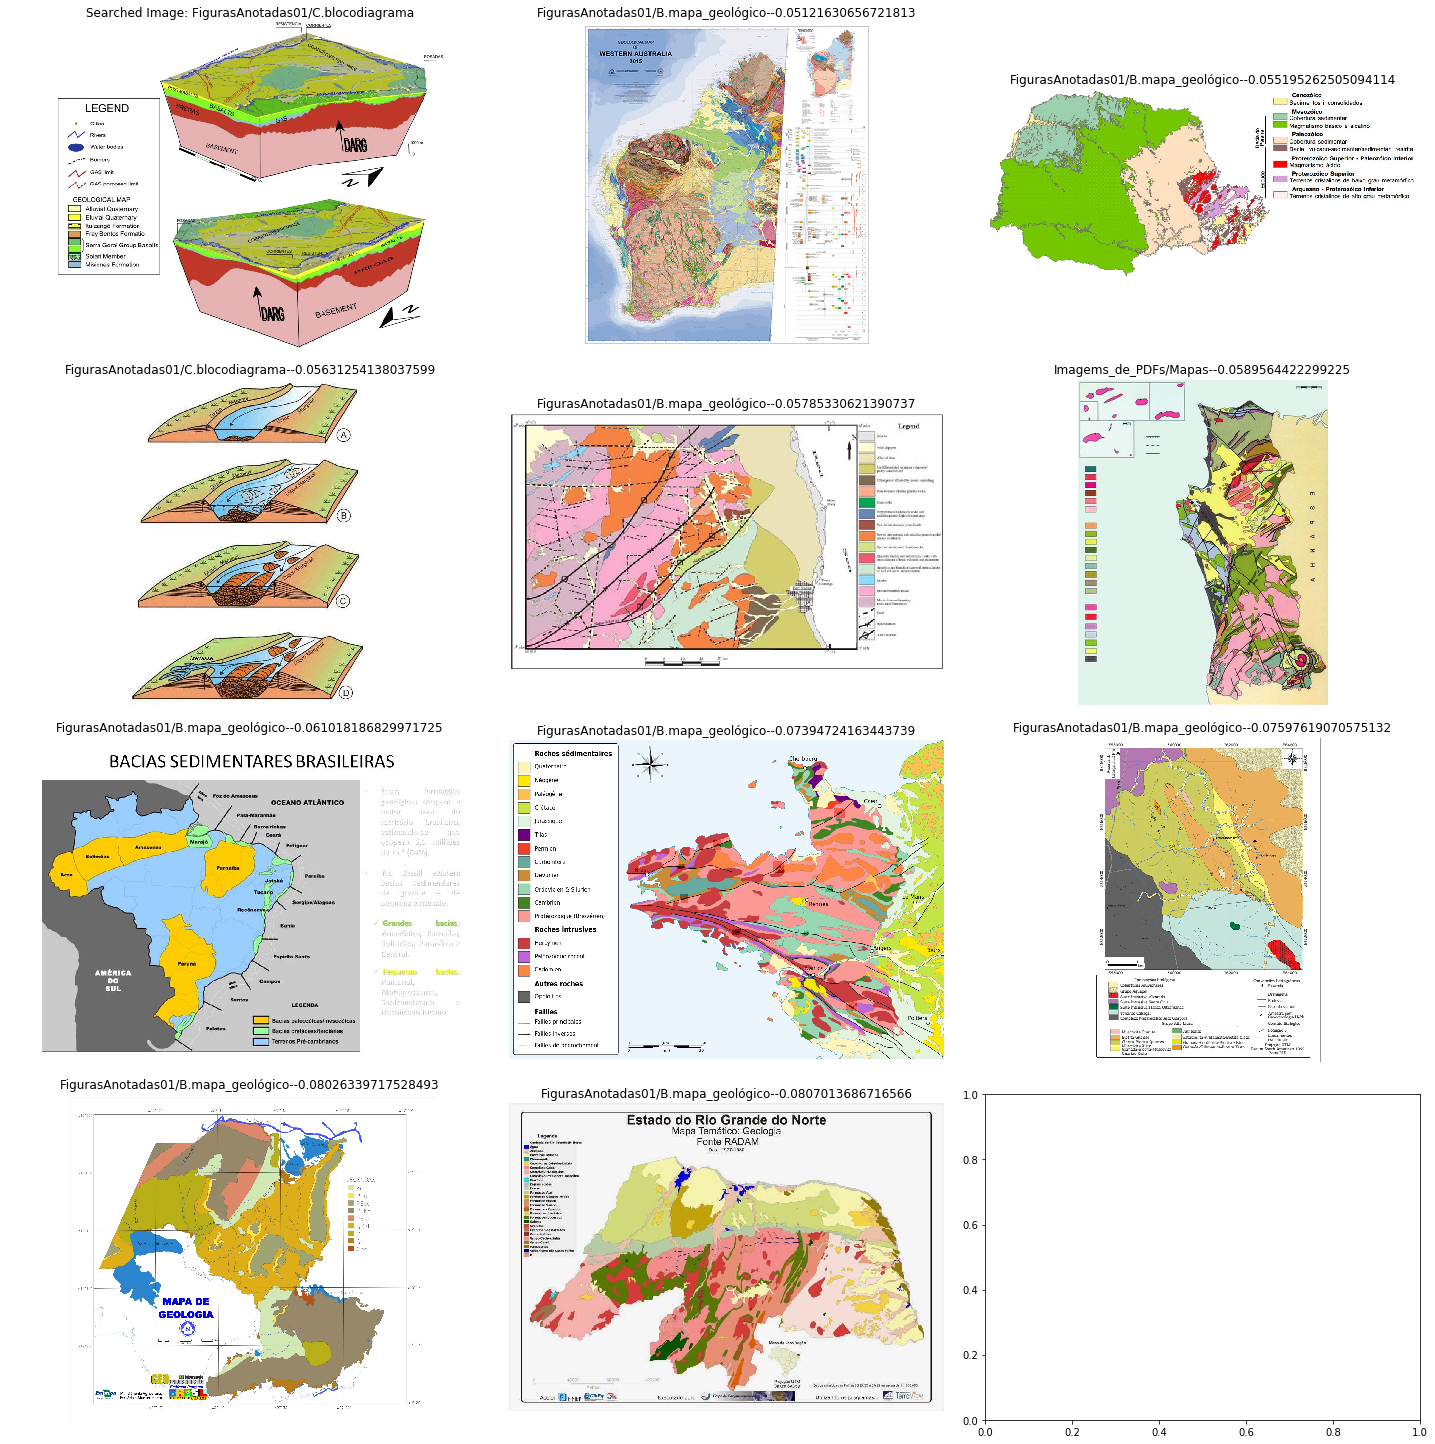

In [22]:
#getting images with lowest distances
images_with_min_distances = get_minimum_distance_images(features[84], data, 10)
errors = calc_stats(images_with_min_distances)
plot_images(images_with_min_distances)